In [ ]:
!python --version

Python 3.10.12


In [ ]:
import torch
torch.__version__

'2.5.1+cu121'

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import os
from torch import nn
from torchvision import transforms


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

import os

# Define base path to Google Drive
base_dir = '/content/drive/MyDrive/ViTs/Image-Classification-Using-Vision-transformer-main'
train_dir = os.path.join(base_dir, 'custom_dateset/train')
test_dir = os.path.join(base_dir, 'custom_dateset/test')
NUM_WORKERS = os.cpu_count()


Mounted at /content/drive


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

# Creating Datasets and DataLoaders

In [ ]:

# Set the image size explicitly to match your dataset
#my images dataset is 200 * 200
IMG_SIZE = 200

# Create enhanced transform pipeline with additional data augmentations
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])
print(f"Enhanced transforms: {manual_transforms}")


Enhanced transforms: Compose(
    Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(200, 200), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    ToTensor()
)


torch.Size([3, 200, 200]) tensor(4)


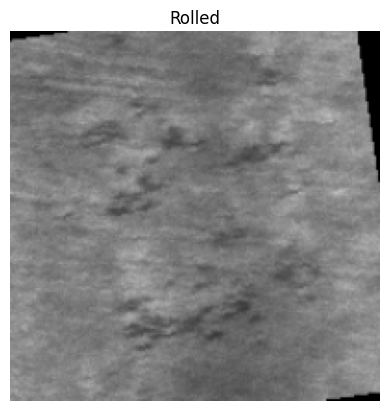

In [ ]:
# choosing the batch size for the dataset so that we upload it, and shown one random image as an example to check our dataset
# Set the batch size
BATCH_SIZE = 16
# Make sure that the dataloaders are created
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0))  # Rearrange image dimensions for matplotlib
plt.title(class_names[label])
plt.axis('off')  # Correct way to turn off the axis in Matplotlib
plt.show()


# Step 1 for working with the ViTs algorithm

#### Tasks:

1- turn an image into patches

2- flatten the patch feature maps into a single dimension

3- Convert the output into Desried output (flattened 2D patches): (100, 1200) -> N×(P2⋅C)       #Current shape: (1, 1200, 100)

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3. Because the images are RGB so 3 channels
        patch_size (int): Size of patches to convert input image into. in my project its 20.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 1200.
        for choosing the embedding_dim we multiply the size of the patch by 3 =  20 * 20 *3 = 1200

    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=20,
                 embedding_dim:int=1200):
        super().__init__()

        # 3. Create a layer to turn an image into patches, help divide the image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

# PatchEmbedding layer ready

In [ ]:
# Let's test it on single image
patch_size =20

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)



set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=20,
                          embedding_dim=1200)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 200, 200])
Output patch embedding shape: torch.Size([1, 100, 1200])


In [ ]:
# View the patch embedding and patch embedding shape


print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.4348,  0.0221, -0.1006,  ..., -0.0636,  0.3222,  0.0008],
         [-0.4022, -0.0493, -0.0801,  ..., -0.0773,  0.4654, -0.0260],
         [-0.3279, -0.0686, -0.0400,  ..., -0.0647,  0.3821, -0.0106],
         ...,
         [-0.3323, -0.0660, -0.0487,  ..., -0.0343,  0.3570, -0.0190],
         [-0.3593,  0.0504, -0.0706,  ..., -0.0184,  0.3913, -0.0187],
         [-0.4229,  0.1307, -0.0441,  ..., -0.1255,  0.3347, -0.2566]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 100, 1200]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Now add the the learnable class embedding and position embeddings
# From start to positional encoding: All in 1 cell

set_seeds()

# 1. Set patch size
patch_size = 20

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=1200)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each


Image tensor shape: torch.Size([3, 200, 200])
Input image with batch dimension shape: torch.Size([1, 3, 200, 200])
Patching embedding shape: torch.Size([1, 100, 1200])
Class token embedding shape: torch.Size([1, 1, 1200])
Patch embedding with class token shape: torch.Size([1, 101, 1200])
Patch and position embedding shape: torch.Size([1, 101, 1200])
tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-4.3483e-01,  2.2095e-02, -1.0061e-01,  ..., -6.3631e-02,
           3.2217e-01,  8.4821e-04],
         [-4.0216e-01, -4.9256e-02, -8.0069e-02,  ..., -7.7337e-02,
           4.6536e-01, -2.5956e-02],
         ...,
         [-3.3234e-01, -6.6038e-02, -4.8655e-02,  ..., -3.4257e-02,
           3.5698e-01, -1.8991e-02],
         [-3.5931e-01,  5.0409e-02, -7.0618e-02,  ..., -1.8359e-02,
           3.9127e-01, -1.8745e-02],
         [-4.2290e-01,  1.3074e-01, -4.4075e-02,  ..., -1.2549e-01,
           3.3471e-01, -2.5657e-01]]], gr

Here we're only creating the class token embedding as torch.ones() for demonstration purposes, in reality, you'd likely create the class token embedding with torch.randn() (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

# Lets create layers used in Transformer's encoder:


#### Norm (LN or LayerNorm) - torch.nn.LayerNorm().

Layer Normalization (torch.nn.LayerNorm() or Norm or LayerNorm or LN) normalizes an input over the last dimension.

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).


#### We can implement the MSA layer in PyTorch with torch.nn.MultiheadAttention() with the parameters:

Multi-Head Self Attention (MSA) - <b>torch.nn.MultiheadAttention()</b>

    embed_dim - the embedding dimension D .

    num_heads - how many attention heads to use (this is where the term "multihead" comes from)

    dropout - whether or not to apply dropout to the attention layer

    batch_first - does our batch dimension come first? (yes it does)

In [ ]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=1200, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

# MLP Block

In [ ]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=1200, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=4800, # MLP size from Table 1 for ViT-Base (for my dataset since embedding_dim is 1200 so we multiply it with 4 = 1200*4=4800)
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

# Creating a Transformer Encoder by combining our custom made layers

In below cell we are creating transformer encoder ourself

In [ ]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=1200, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=4800, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x



#### Transformer Encoder block created!

In [ ]:
!pip install -q torchinfo

transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 101, 1200), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 101, 1200]       [1, 101, 1200]       --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 101, 1200]       [1, 101, 1200]       --                   True
│    └─LayerNorm (layer_norm)                      [1, 101, 1200]       [1, 101, 1200]       2,400                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 101, 1200]       5,764,800            True
├─MLPBlock (mlp_block)                             [1, 101, 1200]       [1, 101, 1200]       --                   True
│    └─LayerNorm (layer_norm)                      [1, 101, 1200]       [1, 101, 1200]       2,400                True
│    └─Sequential (mlp)                            [1, 101, 1200]       [1, 101, 1200]       --                   True
│    │    └─Linear (0)                     

# Let's build a vision transformer

In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=200, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=20, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=1200, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=4800, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=6): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

# Training the Model

In [ ]:
# Train our MOdel

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))


In [ ]:
# Import necessary libraries and mount Google Drive
import sys


# Append the path to the custom module in Google Drive
base_dir = '/content/drive/MyDrive/ViTs/Image-Classification-Using-Vision-transformer-main'
sys.path.append(os.path.join(base_dir, 'going_modular'))

# Import the engine from your custom module
from going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-4, #3e-3,Base LR from Table 3 for ViT-* ImageNet-1k, in my project,changed due to small dataset
                             betas=(0.9, 0.999),
                             weight_decay=0.01) # Reduced weight decay to avoid over-regularization

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=100,
                       device=device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0562 | train_acc: 0.2103 | test_loss: 1.7365 | test_acc: 0.2778
Epoch: 2 | train_loss: 1.8175 | train_acc: 0.2254 | test_loss: 1.7479 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.7408 | train_acc: 0.2686 | test_loss: 1.6944 | test_acc: 0.2708
Epoch: 4 | train_loss: 1.4338 | train_acc: 0.3972 | test_loss: 1.3404 | test_acc: 0.4583
Epoch: 5 | train_loss: 1.2117 | train_acc: 0.4874 | test_loss: 1.3268 | test_acc: 0.4583
Epoch: 6 | train_loss: 1.1195 | train_acc: 0.5385 | test_loss: 1.0969 | test_acc: 0.5208
Epoch: 7 | train_loss: 1.0832 | train_acc: 0.5481 | test_loss: 1.0485 | test_acc: 0.4792
Epoch: 8 | train_loss: 1.0202 | train_acc: 0.5577 | test_loss: 0.9297 | test_acc: 0.6181
Epoch: 9 | train_loss: 0.9777 | train_acc: 0.5986 | test_loss: 0.9314 | test_acc: 0.5694
Epoch: 10 | train_loss: 0.9647 | train_acc: 0.5974 | test_loss: 0.9153 | test_acc: 0.6181
Epoch: 11 | train_loss: 0.9575 | train_acc: 0.5992 | test_loss: 0.9173 | test_acc: 0.5903
Epoch: 12 | train_l

Our ViT model has come to life!

Results on our custom dataset don't look too good.

Lets evaluate the model

Confusion Matrix:
 [[22  0  2  0  0  0]
 [ 0 19  0  1  3  1]
 [ 0  0 23  0  0  1]
 [ 3  0  1 18  1  1]
 [13  0  0  0 10  1]
 [ 0  3  0  0  0 21]]
Classification Report:
               precision    recall  f1-score   support

     Crazing       0.58      0.92      0.71        24
   Inclusion       0.86      0.79      0.83        24
     Patches       0.88      0.96      0.92        24
      Pitted       0.95      0.75      0.84        24
      Rolled       0.71      0.42      0.53        24
   Scratches       0.84      0.88      0.86        24

    accuracy                           0.78       144
   macro avg       0.80      0.78      0.78       144
weighted avg       0.80      0.78      0.78       144



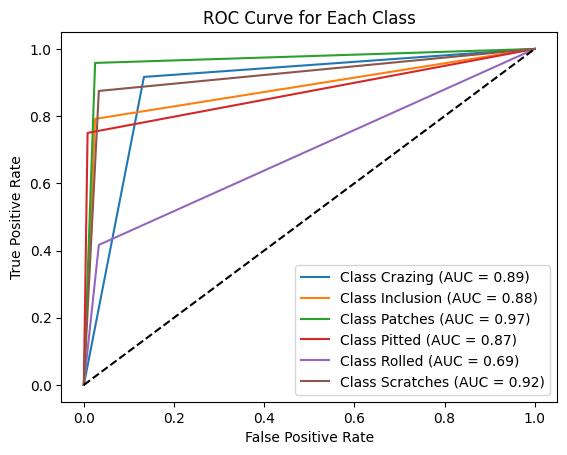

In [ ]:
# Import necessary libraries for evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Assuming that training is already done and we have the trained model named 'model'

# Function to evaluate model and print metrics
def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_labels = []
    all_preds = []

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", conf_matrix)

    # Classification report (including precision, recall, f1-score)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:\n", report)

    # Plot ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    all_labels_one_hot = np.eye(len(class_names))[all_labels]

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], (np.array(all_preds) == i).astype(int))
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='lower right')
    plt.show()  # Display the plot in Google Colab

# Evaluate the model
evaluate_model(vit, test_dataloader, class_names, device)


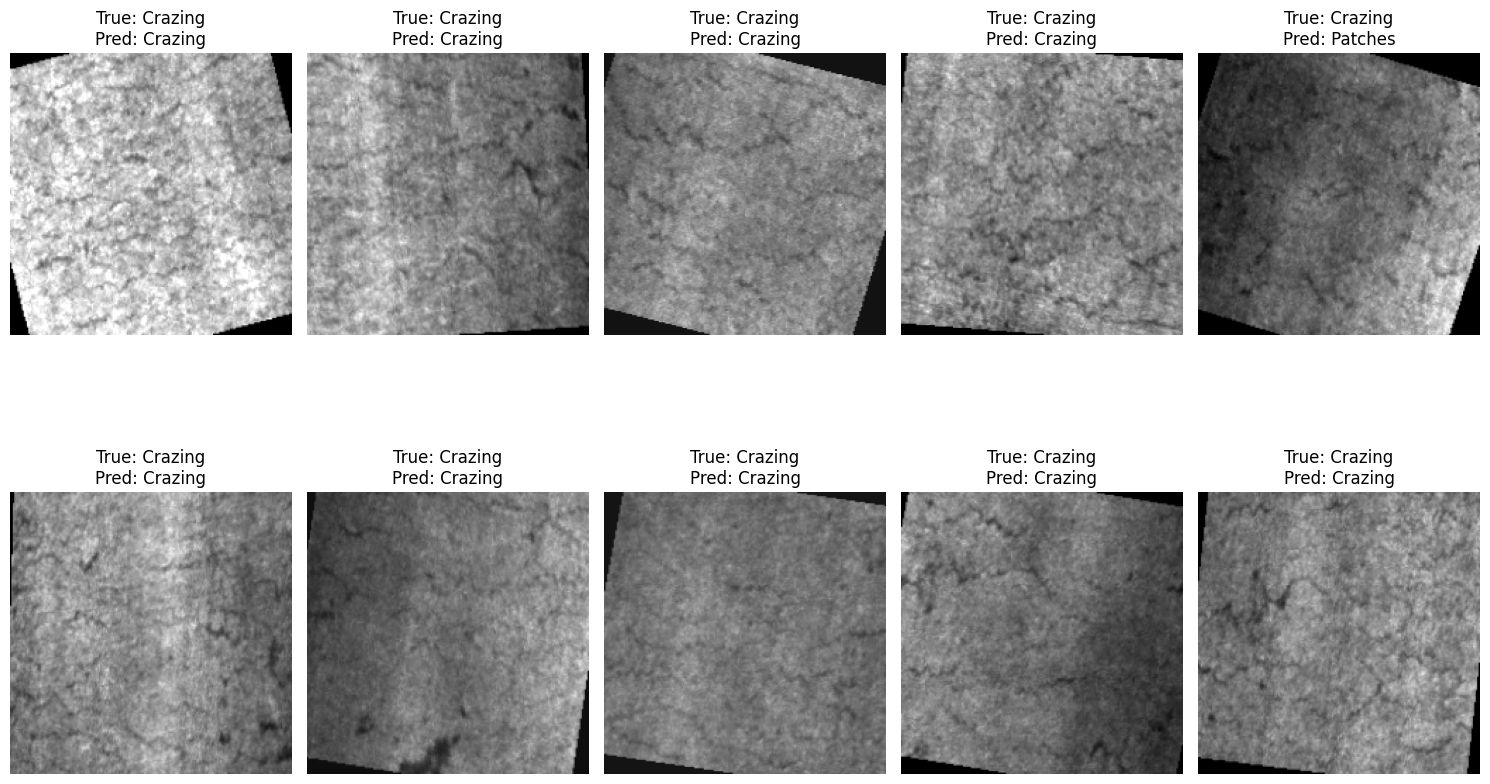

In [ ]:
# Importing the random library

import random



# Function to display 10 test images with predictions
def show_predictions(model, dataloader, class_names, device):
    model.eval()
    images_shown = 0
    fig = plt.figure(figsize=(15, 10))
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown == 10:
                    break
                images_shown += 1
                image = inputs[i].cpu().permute(1, 2, 0).numpy()
                true_label = class_names[labels[i]]
                predicted_label = class_names[preds[i]]

                ax = fig.add_subplot(2, 5, images_shown)
                ax.imshow(image)
                ax.set_title(f'True: {true_label}\nPred: {predicted_label}')
                ax.axis('off')
            if images_shown == 10:
                break
    plt.tight_layout()
    plt.show()



# Show 10 images with predictions
show_predictions(vit, test_dataloader, class_names, device)


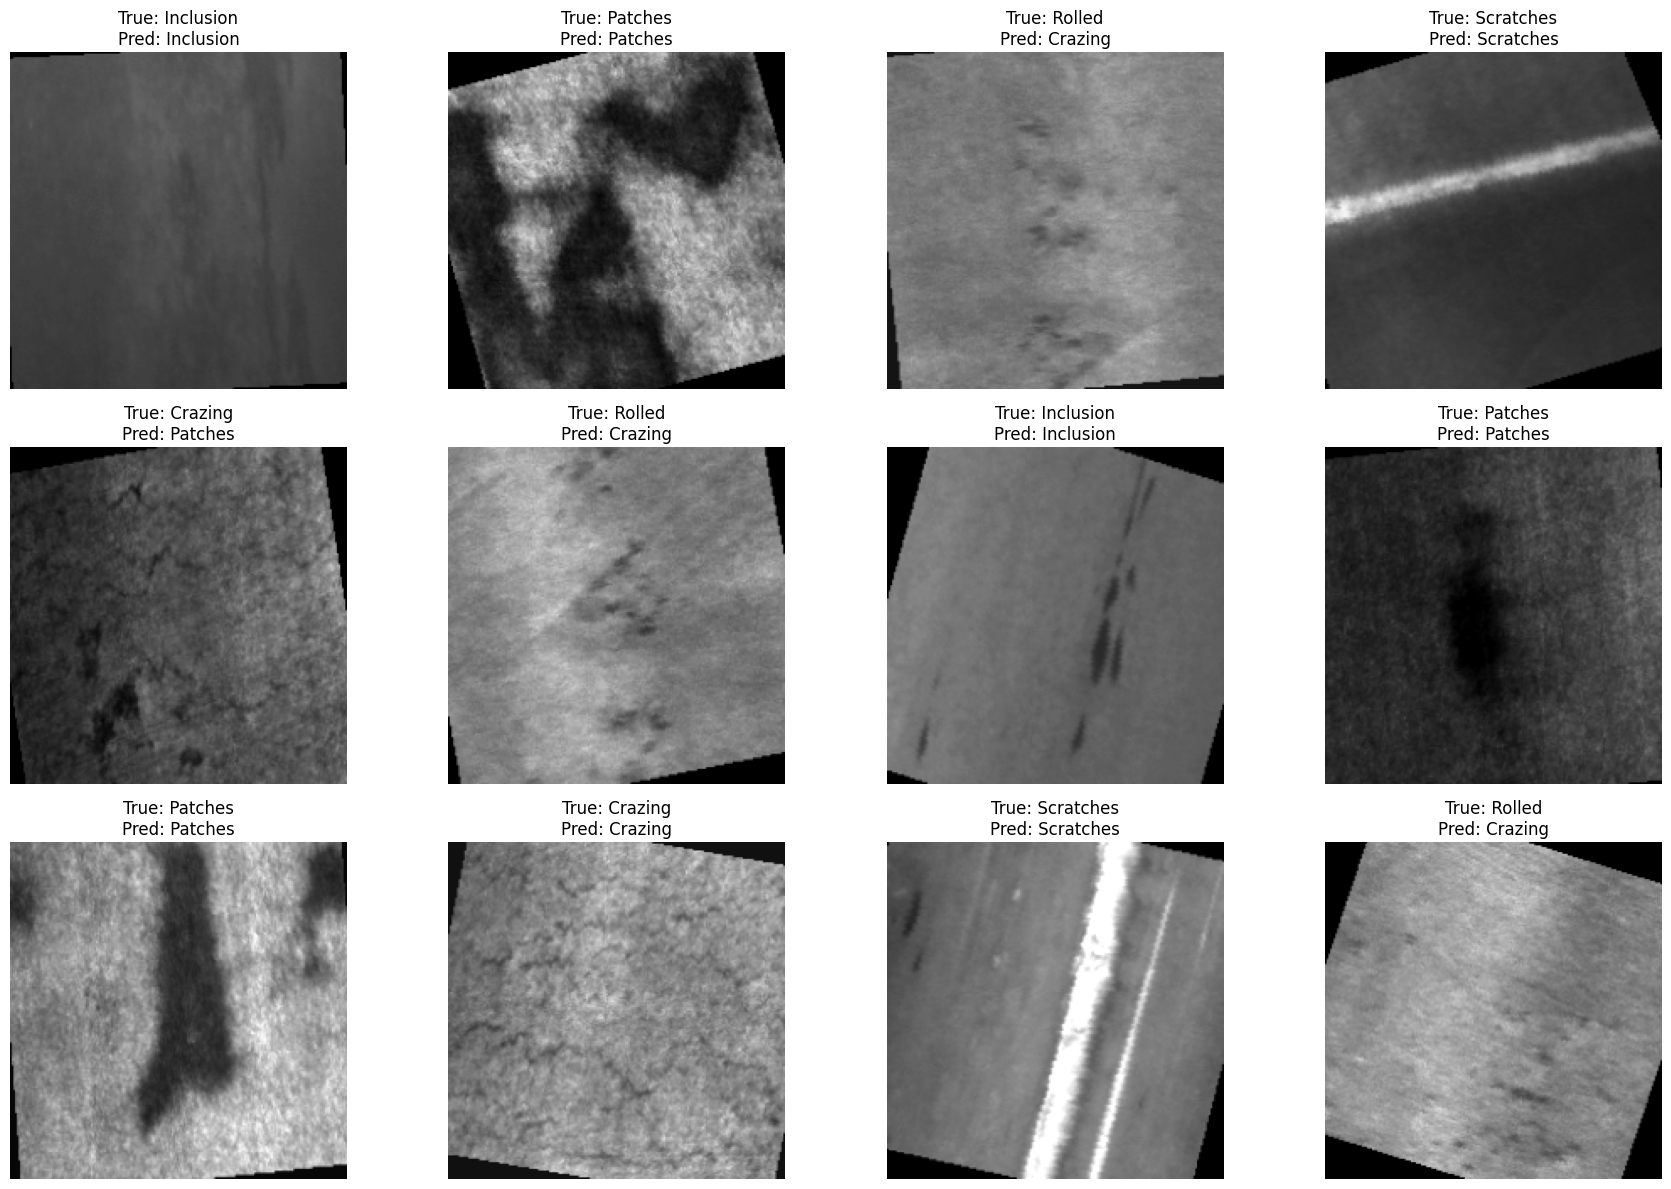

In [ ]:


# Function to display 12 test images from random classes with predictions
def show_predictions(model, dataloader, class_names, device):
    model.eval()
    fig = plt.figure(figsize=(18, 12))
    shown_images = []

    with torch.no_grad():
        # Get all data in one pass to randomly select images later
        all_inputs, all_labels = [], []
        for inputs, labels in dataloader:
            all_inputs.append(inputs)
            all_labels.append(labels)

        all_inputs = torch.cat(all_inputs)
        all_labels = torch.cat(all_labels)
        indices = list(range(len(all_inputs)))
        random.shuffle(indices)

        images_shown = 0
        for idx in indices:
            if images_shown == 12:
                break

            input_img = all_inputs[idx].unsqueeze(0).to(device)
            label = all_labels[idx].to(device)
            output = model(input_img)
            _, pred = torch.max(output, 1)

            image = input_img[0].cpu().permute(1, 2, 0).numpy()
            true_label = class_names[label]
            predicted_label = class_names[pred]

            ax = fig.add_subplot(3, 4, images_shown + 1)
            ax.imshow(image)
            ax.set_title(f'True: {true_label}\nPred: {predicted_label}')
            ax.axis('off')
            images_shown += 1

    plt.tight_layout()
    plt.show()



# Show 12 images with predictions from random classes
show_predictions(vit, test_dataloader, class_names, device)
